# Using NN with appropriate loss functions for fitting flexible regression models

**Goal:** 
In this notebook you will learn how to step-wise adapt the NN architecture and the loss function to develop a regression model that achieves a good fit. You will use a simulated dataset with two variables (x,y) which show a non-linear dependency of y on x and a non-constant data variablilty. You will see that you need to add nonlinear hidden layers if you want to model nonlinear relationships. In addition you will need a NN with two output nodes when you want to model a Normal CPD with parameters $\mu$ and $\sigma$, especially if $\sigma$ is not constant (heteroscedastic).

**Usage:**  
Before working through this notebook we recommend to read chapter 4.3. The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it. 

**Dataset:** 
A simulated dataset with a sine wave that has a small positive linear trend and a variance that depends on the amplitude.

**Content:**
* Simulate a dataset with non-linear relationship between x and y and changing data variablility.
* View regression as model for the Normal CPD where the mean and the standard deviation depend on x.
* Fist model:   
Use a NN without hidden layers and with one output node to fit a linear regression where only the mean parameter of the CPD depends on x. The loss function is given by the NLL which reduces to the MSE if you assume constant variance.
* Second model:  
Use a NN with hidden layers and with one output node to fit a linear regression where the mean parameter of the CPD can non-linearly depend on x. The loss function is given by the NLL which reduces to the MSE if you assume constant variance.
*  Third model:  
Use a NN with hidden layers and two output nodes to fit a linear regression where the mean and the standard-deviation parameter of the CPD can non-linearly depend on x. The loss function is given by the NLL which no longer reduces to the MSE because you don't assume a constant variance.


| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_04/nb_ch04_04.ipynb)



#### Imports
In the next three cells, we load all the required libraries and simulate and plot a dataset with a sine wave that has small linear slope and variace that gets bigger with the amplitude.


In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.1.0-rc1  running in colab?:  True


In [3]:
#load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from tensorflow.keras import optimizers

tf.__version__

'2.1.0-rc1'

#### Simulate some data and visualize them 

In [0]:
def create_sine_data(n = 300):
    np.random.seed(32)
    n = 300
    x = np.linspace(0,1*2*np.pi,n)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60)))
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
    y2 = 0.1*x+1
    y=y1+y2
    return x,y

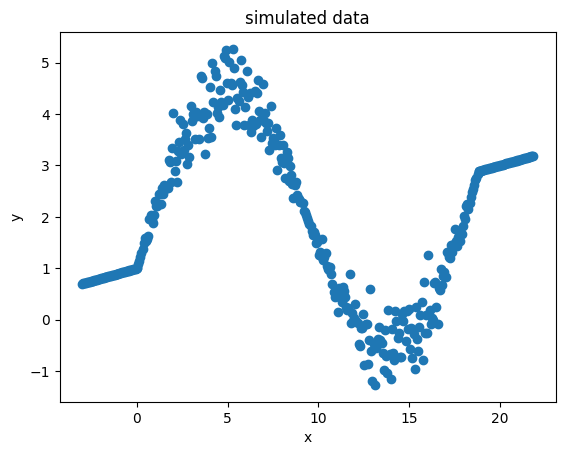

In [5]:
## use custom function to simulate some data 
x,y = create_sine_data(n=300) #A
plt.scatter(x=x,y=y,marker='o')
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
n=len(x)

## First model: NN for the most simple linear regression 

Let's use a NN without a hidden layer and with one output node to fit a linear regression model where the mean parameter of the CPD linearly depends on x. Since the variance is not modeled, the loss function or NLL is given by the MSE (see derivation in chapter 4.3).

In [0]:
# set up a NN without hidden layer and only one output node 
# This assumes that the mean of the CPD depends linearly on x
# and the standard deviation of the CPD is constant and not modeled
model = Sequential()
model.add(Dense(1, activation='linear',batch_input_shape=(None, 1)))
model.compile(loss='mean_squared_error',optimizer="adam")

In [7]:
# summarize model along with number of model weights
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


#### Train the first model and show the fit along with the data

In [0]:
# train the model  
history=model.fit(x, y, 
                  batch_size=16, 
                  epochs=1000,
                  verbose=0, 
                 )

In [9]:
# evaluation of the MSE loss
model.evaluate(x,y)

420/420 [==============================] - 0s 140us/sample - loss: 2.4831


2.4830858923140027

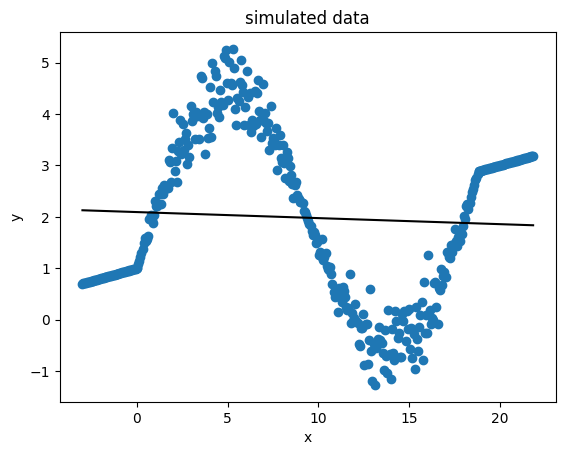

In [10]:
# show the data along with the fit
plt.scatter(x=x,y=y,marker='o')
plt.plot(x,model.predict(x),c="black")
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


As you can see the linear model is not able the fit the data. This is no surpise because you didn't use any hidden layers and without them it is not possible to model non-linear dependencies. 

In [11]:
# get model parameters: slope and intercept of the linear model
model.get_weights()

[array([[-0.01173406]], dtype=float32), array([2.0924492], dtype=float32)]

## Second model: NN for a non-linear  regression model

Now, let's use a NN with three hidden layers and with one output node to fit a linear regression model where the mean parameter of the CPD can non-linearly depend on x. Since the variance is not modeled, the loss function or NLL is given by the MSE (see derivation in chapter 4.3).

#### Listing 4.5 A fully connected NN with 3 hidden layers to model non-linear relation ships using the MSE loss                                                                                                                                                                                                                        


In [0]:
# set up a NN with 3 hidden layers and only one output node 
# This allows that the mean of the CPD depends non-linearly on x
# and the standard deviation of the CPD is constant and not modeled
model = Sequential()
model.add(Dense(20, activation='relu',
                batch_input_shape=(None, 1)))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error',optimizer="adam")

In [13]:
# summarize model along with number of model weights
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                40        
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1050      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 2,131
Trainable params: 2,131
Non-trainable params: 0
_________________________________________________________________


#### Train the second model and show the fit along with the data

In [0]:
# train the model
history=model.fit(x, y, 
                  batch_size=16, 
                  epochs=1000,
                  verbose=0, 
                 )

In [15]:
# evaluation of the MSE loss
model.evaluate(x,y)

420/420 [==============================] - 0s 181us/sample - loss: 0.0709


0.07092591130307742

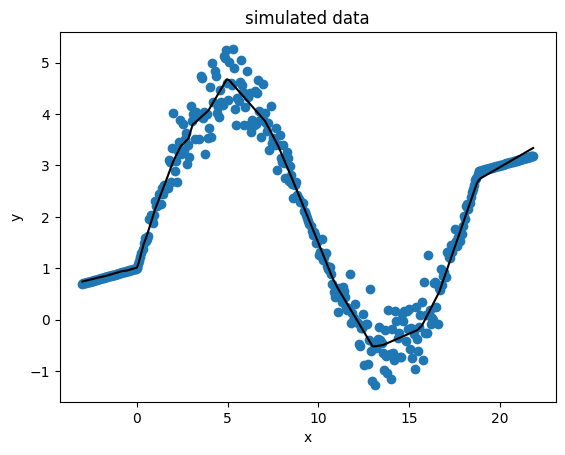

In [16]:
# show the data along with the fit
plt.scatter(x=x,y=y,marker='o')
plt.plot(np.linspace(-3,3*2*np.pi+3,1000),model.predict(np.linspace(-3,3*2*np.pi+3,1000)),c="black")
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

As you can see now, the NN with hidden layers is able the fit the data nicely. Let's try to capure also the data variance.

## Third model: NN for a non-linear  regression model with changing variance

Now, we want to use a NN with again three hidden layers but this time with two output nodes to fit a linear regression model where the mean $\mu$ and the standard-deviation $\sigma$ parameter of the CPD can non-linearly depend on x. Since the variance is now also modeled, the loss function, which is the NLL is not anymore given by the MSE but has a more complicated form (see derivation in chapter 4.3). Keras does not provide this loss function therefore you we have to define it by ourself.

#### Listing 4.6 A fully connected NN with hidden layers, two output nodes and a custom loss to fit al non-linear heteroscatic regression model                                                                                                                                                                                                                        


In [0]:
# define loss function that corresponds to NLL  
import math
def my_NLL_loss(y_true,y_pred):
  mu=tf.slice(y_pred,[0,0],[-1,1])              # A     
  sigma=tf.math.exp(tf.slice(y_pred,[0,1],[-1,1]))   # B 
  
  a=1/(tf.sqrt(2.*math.pi)*sigma) 
  b1=tf.square(mu-y_true)
  b2=2*tf.square(sigma)
  b=b1/b2
  
  loss = tf.reduce_sum(-tf.math.log(a)+b,axis=0)
  return loss

#A extract first column for μ 
#B extract second column for σ

In [0]:
# set up the model with3  hidden layers and 2 output nodes
# This allows that the mean of the CPD depends non-linearly on x
# and also the standard deviation can depend non-linearly on x
model =  Sequential()
model.add(Dense(20, activation='relu',batch_input_shape=(None, 1)))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(2, activation='linear'))

model.compile(loss=my_NLL_loss,optimizer="adam",metrics=[my_NLL_loss])


In [19]:
# summarize model along with number of model weights
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 20)                40        
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1050      
_________________________________________________________________
dense_7 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 42        
Total params: 2,152
Trainable params: 2,152
Non-trainable params: 0
_________________________________________________________________


#### Train the third model and show the fit along with the data

In [0]:
# train the model
history=model.fit(x, y, 
                  batch_size=16, 
                  epochs=1000,
                  verbose=0
                 )

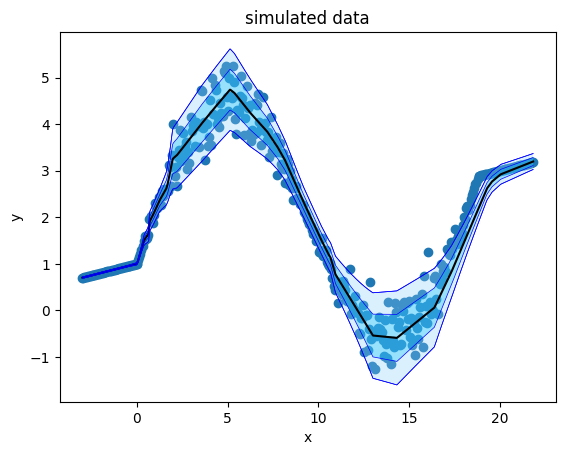

In [21]:
# show the data along with the fit plus/minus 2-times the standard deviation
x_pred=np.linspace(-3,3*2*np.pi+3,1000).reshape(1000,1)
pred_mu=model.predict(np.linspace(-3,3*2*np.pi+3,1000).reshape(1000,1))[:,0]
pred_log_sigma=model.predict(np.linspace(-3,3*2*np.pi+3,1000).reshape(1000,1))[:,1]
plt.scatter(x,y,marker='o')
plt.plot(x_pred,pred_mu,c="black")

pred_1_sd_p = pred_mu+(np.exp(pred_log_sigma))
pred_1_sd_m = pred_mu-(np.exp(pred_log_sigma))

plt.plot(x_pred,pred_1_sd_p, 'b', linewidth=0.5)
plt.plot(x_pred,pred_1_sd_m, 'b', linewidth=0.5)

pred_2_sd_p = pred_mu+2*(np.exp(pred_log_sigma))
pred_2_sd_m = pred_mu-2*(np.exp(pred_log_sigma))

plt.plot(x_pred,pred_2_sd_p, 'b', linewidth=0.5)
plt.plot(x_pred,pred_2_sd_m, 'b', linewidth=0.5)

plt.plot(x_pred,pred_mu+2*(np.exp(pred_log_sigma)), 'b', linewidth=0.5)
plt.plot(x_pred,pred_mu-2*(np.exp(pred_log_sigma)), 'b', linewidth=0.5)

plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([pred_2_sd_p,
                         pred_2_sd_m[::-1]]),alpha=0.3, fc='lightskyblue', ec='None')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([pred_1_sd_p,
                         pred_1_sd_m[::-1]]),alpha=0.3, fc='deepskyblue', ec='None')
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Smoothness of the fit dependance on the activation function

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  


*Exercise 1: Change the activations in the last network form relu to sigmoid and redo the analysis. What do you observe?*

In [0]:
# Write your code here

Scroll down to see the solution.

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

In [0]:
# set up the model with3  hidden layers and 2 output nodes
# This allows that the mean of the CPD depends non-linearly on x
# and also the standard deviation can depend non-linearly on x
model =  Sequential()
model.add(Dense(20, activation='sigmoid',batch_input_shape=(None, 1)))
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(2, activation='linear'))

model.compile(loss=my_NLL_loss,optimizer="adam",metrics=[my_NLL_loss])

In [24]:
# summarize model along with number of model weights
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 20)                40        
_________________________________________________________________
dense_10 (Dense)             (None, 50)                1050      
_________________________________________________________________
dense_11 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 42        
Total params: 2,152
Trainable params: 2,152
Non-trainable params: 0
_________________________________________________________________


In [0]:
# train the model
history=model.fit(x, y, 
                  batch_size=16, 
                  epochs=1500,
                  verbose=0
                 )

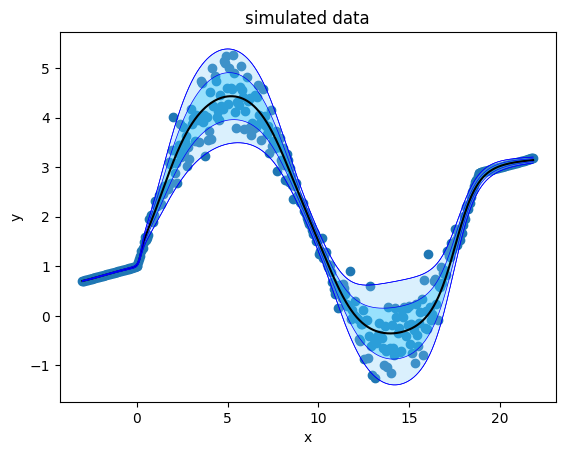

In [26]:
# show the data along with the fit plus/minus 2-times the standard deviation
x_pred=np.linspace(-3,3*2*np.pi+3,1000).reshape(1000,1)
pred_mu=model.predict(np.linspace(-3,3*2*np.pi+3,1000).reshape(1000,1))[:,0]
pred_log_sigma=model.predict(np.linspace(-3,3*2*np.pi+3,1000).reshape(1000,1))[:,1]
plt.scatter(x,y,marker='o')
plt.plot(x_pred,pred_mu,c="black")

pred_1_sd_p = pred_mu+(np.exp(pred_log_sigma))
pred_1_sd_m = pred_mu-(np.exp(pred_log_sigma))

plt.plot(x_pred,pred_1_sd_p, 'b', linewidth=0.5)
plt.plot(x_pred,pred_1_sd_m, 'b', linewidth=0.5)

pred_2_sd_p = pred_mu+2*(np.exp(pred_log_sigma))
pred_2_sd_m = pred_mu-2*(np.exp(pred_log_sigma))

plt.plot(x_pred,pred_2_sd_p, 'b', linewidth=0.5)
plt.plot(x_pred,pred_2_sd_m, 'b', linewidth=0.5)

plt.plot(x_pred,pred_mu+2*(np.exp(pred_log_sigma)), 'b', linewidth=0.5)
plt.plot(x_pred,pred_mu-2*(np.exp(pred_log_sigma)), 'b', linewidth=0.5)

plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([pred_2_sd_p,
                         pred_2_sd_m[::-1]]),alpha=0.3, fc='lightskyblue', ec='None')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([pred_1_sd_p,
                         pred_1_sd_m[::-1]]),alpha=0.3, fc='deepskyblue', ec='None')
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


#### Solution 
When using sigmoid as activation function you get a different result: The curves for the fit (mean) and also the curves for the reference interval (mean plus/minus 2-times stddev) now apprear much smoother. This effect is probably due to the fact that relus are not smooth and if you change the input to a ReLU from negative to small positive, it gets activated and contributes to the output. We also observe that we need to train for more epochs with sigmoids than with relus, this is due the smaller gradients and updatesteps that backpropagate with the sigmoid activation.